# Chracter prediction



In [2]:
import numpy as np 
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical 
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional

In [3]:
# Define path for file with sonnets

# Read the data
with open('../data/names/English.txt') as f:
    data = f.read()

# Convert to lower case and save as a list
# corpus = data.lower().split("\n")
corpus = [name.lower() + "_" for name in data.split('\n') if name.strip()]
print(f"There are {len(corpus)} lines of names\n")
print(f"The first 5 lines look like this:\n")
for i in range(5):
  print(corpus[i])

There are 3668 lines of names

The first 5 lines look like this:

abbas_
abbey_
abbott_
abdi_
abel_


## Tokenizing the text

Now fit the Tokenizer to the corpus and save the total number of words.

In [4]:
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(corpus)
total_chars = len(tokenizer.word_index) + 1

In [16]:
corpus[0]

'abbas'

In [19]:
tokenizer.texts_to_sequences([corpus[0]])[0]

[4, 19, 19, 4, 8]

### Generating n_grams


In [5]:
#  n_gram_seqs
def n_gram_seqs(corpus, tokenizer):
    input_sequences = []
    
    # Loop over every line
    for line in corpus:

      # Tokenize the current line
      token_list = tokenizer.texts_to_sequences([line])[0]

      # Loop over the line several times to generate the subphrases
      for i in range(1, len(token_list)):
        
        # Generate the subphrase
        n_gram_sequence = token_list[:i+1]

        # Append the subphrase to the sequences list
        input_sequences.append(n_gram_sequence)
    
    return input_sequences

In [ ]:
# Test  function 
next_3_examples_sequence = n_gram_seqs(corpus[1:4], tokenizer)

print("n_gram sequences for next 3 examples look like this:\n")
next_3_examples_sequence

n_gram sequences for next 3 examples look like this:



[[4, 19],
 [4, 19, 19],
 [4, 19, 19, 1],
 [4, 19, 19, 1, 15],
 [4, 19],
 [4, 19, 19],
 [4, 19, 19, 6],
 [4, 19, 19, 6, 7],
 [4, 19, 19, 6, 7, 7],
 [4, 19],
 [4, 19, 10],
 [4, 19, 10, 9]]

In [6]:
# Apply the n_gram_seqs transformation to the whole corpus
input_sequences = n_gram_seqs(corpus, tokenizer)

# Save max length 
max_sequence_len = max([len(x) for x in input_sequences])

print(f"n_grams of input_sequences have length: {len(input_sequences)}")
print(f"maximum length of sequences is: {max_sequence_len}")

n_grams of input_sequences have length: 23457
maximum length of sequences is: 15


### Add padding to the sequences


In [7]:
#  pad_seqs
def pad_seqs(input_sequences, maxlen):
    
    padded_sequences = np.array(pad_sequences(input_sequences, maxlen=maxlen))
    
    return padded_sequences


In [ ]:
# Test 
first_padded_seq = pad_seqs(first_example_sequence, (1+len(first_example_sequence)))
first_padded_seq

array([[ 0,  0,  0,  4, 19],
       [ 0,  0,  4, 19, 19],
       [ 0,  4, 19, 19,  4],
       [ 4, 19, 19,  4,  8]])

In [ ]:
# Test function 
next_3_padded_seq = pad_seqs(next_3_examples_sequence, max([len(s) for s in next_3_examples_sequence]))
next_3_padded_seq

array([[  0,   0,   0,   0,   0,   0,   8, 878],
       [  0,   0,   0,   0,   0,   8, 878, 134],
       [  0,   0,   0,   0,   8, 878, 134, 351],
       [  0,   0,   0,   8, 878, 134, 351, 102],
       [  0,   0,   8, 878, 134, 351, 102, 156],
       [  0,   8, 878, 134, 351, 102, 156, 199],
       [  0,   0,   0,   0,   0,   0,  16,  22],
       [  0,   0,   0,   0,   0,  16,  22,   2],
       [  0,   0,   0,   0,  16,  22,   2, 879],
       [  0,   0,   0,  16,  22,   2, 879,  61],
       [  0,   0,  16,  22,   2, 879,  61,  30],
       [  0,  16,  22,   2, 879,  61,  30,  48],
       [ 16,  22,   2, 879,  61,  30,  48, 634],
       [  0,   0,   0,   0,   0,   0,  25, 311],
       [  0,   0,   0,   0,   0,  25, 311, 635],
       [  0,   0,   0,   0,  25, 311, 635, 102],
       [  0,   0,   0,  25, 311, 635, 102, 200],
       [  0,   0,  25, 311, 635, 102, 200,  25],
       [  0,  25, 311, 635, 102, 200,  25, 278]], dtype=int32)

In [8]:
# Pad the whole corpus
input_sequences = pad_seqs(input_sequences, max_sequence_len)

print(f"padded corpus has shape: {input_sequences.shape}")

padded corpus has shape: (23457, 15)


In [9]:
#  features_and_labels
def features_and_labels(input_sequences, total_chars):
    
    features = input_sequences[:,:-1]
    labels = input_sequences[:,-1]
    one_hot_labels = to_categorical(labels, num_classes=total_chars)

    return features, one_hot_labels

In [10]:
# Split the whole corpus
features, labels = features_and_labels(input_sequences, total_chars)

print(f"features have shape: {features.shape}")
print(f"labels have shape: {labels.shape}")

features have shape: (23457, 14)
labels have shape: (23457, 29)


In [11]:
#  create_model
def create_model(total_chars, max_sequence_len):
        
    model = Sequential()
    model.add(Embedding(total_chars, 100, input_length=max_sequence_len-1))
    model.add(Bidirectional(LSTM(150)))
    model.add(Dense(total_chars, activation='softmax'))


    # Compile the model
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    

    return model

In [12]:
# Get the untrained model
model = create_model(total_chars, max_sequence_len)

# Train the model
history = model.fit(features, labels, epochs=50, verbose=1)

c:\Users\Yoseph\.conda\envs\dataenv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/50
734/734 ━━━━━━━━━━━━━━━━━━━━ 15s 13ms/step - accuracy: 0.2437 - loss: 2.6137
Epoch 2/50
734/734 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.3467 - loss: 2.1141
Epoch 3/50
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.3752 - loss: 1.9905
Epoch 4/50
734/734 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - accuracy: 0.4009 - loss: 1.9045
Epoch 5/50
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.4239 - loss: 1.8185
Epoch 6/50
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.4327 - loss: 1.7724
Epoch 7/50
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.4456 - loss: 1.7095
Epoch 8/50
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.4704 - loss: 1.6427
Epoch 9/50
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.4760 - loss: 1.5909
Epoch 10/50
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.4871 - loss: 1.5613
Epoch 11/50
734/734 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.4981 - loss: 1.5261
Epoch 12/50
734/734 ━━━━━━━━━━━

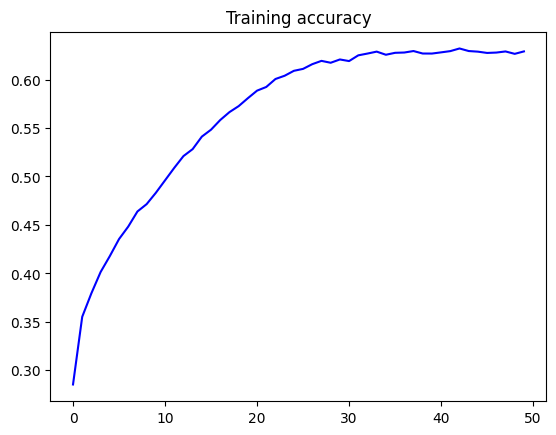

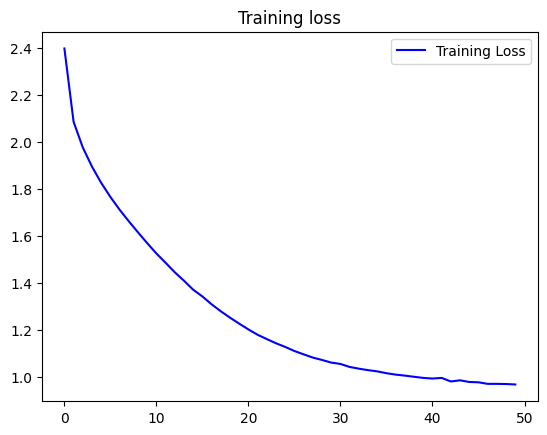

In [13]:
# Take a look at the training curves of your model

acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [ ]:
seed_text = "ab"
next_chars = 14
  
for _ in range(next_chars):
	# Convert the text into sequences
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	# Pad the sequences
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	# Get the probabilities of predicting a word
	predicted = model.predict(token_list, verbose=0)
	# Choose the next word based on the maximum probability
	predicted = np.squeeze(predicted)
	predicted_char_index = np.random.choice(len(predicted), p=predicted)
	# print(predicted_char_index)
	output_char = tokenizer.index_word[predicted_char_index]
	
	if output_char == "_":
		break
	# Append to the current text
	seed_text +=  output_char

print(seed_text)


abraham
